# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Definicja stałych

In [2]:
# nieskończoność
INF = float("inf")

# generowanie odcinków
MIN_X = 0
MIN_Y = 0

# porównywanie punktów
EPS = 10 ** -12

# typy zdarzeń
BEG = 0
END = 1
INTERSECT = 2

# konfiguracja wizualizacji
BROOM = {"color" : "red", "linestyle" : '--', "linewidth" : 2}
IN_EVENTS_STRUCT = {"color" : ["green"]}
CURRENT_VERTEX = {"color" : ["cyan"]}
PROCESSED_VERTICIES = {"color" : ["blue"]}
FOUND_INTERSECTION_POINT = {"color" : ["red"], "s" : 70}
IN_BROOM_STRUCT = {"color" : ["purple"]}
PROCESSED_SEGMENTS = {"color" : ["blue"]}
NOT_PROCESSED_SEGMENTS = {"color" : ["orange"]}

# Przydatne funkcje 

In [3]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()

def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


In [4]:
def draw_segments(segments):
    plt.close("all")
    vis = Visualizer()
    vis.add_line_segment(segments)
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

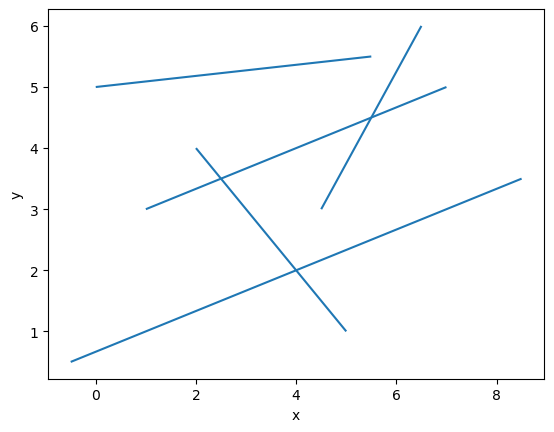

In [5]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

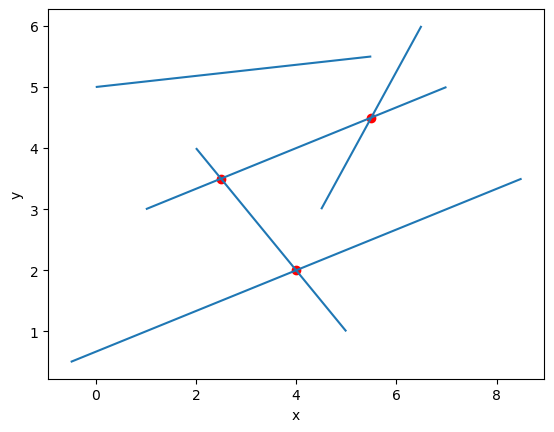

In [6]:
draw_example_2()

## Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [7]:
import random

In [8]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów.
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """

    uniformSections = []
    sectionsEndsXCoordinate = set()

    while len(uniformSections) < n:
        x1 = random.uniform(MIN_X, max_x)
        x2 = random.uniform(MIN_X, max_x)

        if x1 == x2 or x1 in sectionsEndsXCoordinate or x2 in sectionsEndsXCoordinate:
            continue

        sectionsEndsXCoordinate.add(x1)
        sectionsEndsXCoordinate.add(x2)

        y1 = random.uniform(MIN_Y, max_y)
        y2 = random.uniform(MIN_Y, max_y)

        section = ((x1, y1), (x2, y2))
        uniformSections.append(section)

    return uniformSections

In [9]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.127s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [55]:
sections = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

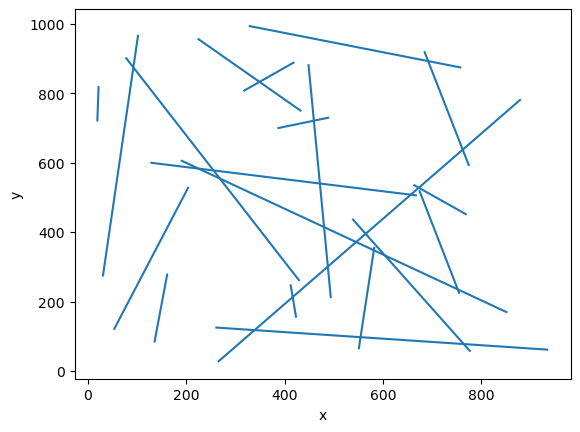

In [56]:
vis = Visualizer()
vis.add_line_segment(sections)
vis.show()

## Wprowadzenie odcinków myszką

Uzupełnij funkcję ```get_segments``` #interaktywne dodawanie odcinków przez rysowanie myszką

In [12]:
def get_segments():
    """
    Odczytuje punkty wprowadzone przez użytkownika myszką i zwraca listę odcinków jako krotki punktów, które są
    krotkami liczb zmiennoprzecinkowych.
    Wewnątrz Jupyter Notebook używać wraz z ***%matplotlib widget***

    :return list of tuple: Lista, w której każdy element jest krotką krotek reprezentujących odcinki ((x1, y1), (x2, y2)).
    """
    # Event handler for mouse click
    def on_click(event):
        nonlocal pickSegmentBeg, segmentBegX, segmentBegY
        # Check if it's a left-click within the axes
        if event.button == 1 and event.inaxes == ax:
            # Append the point and update the plot
            currX, currY = event.xdata, event.ydata
            ax.scatter(currX, currY, color = "blue", marker = 'o')  # Mark the point

            # check if it is first or second point in line segment
            if pickSegmentBeg:
                segmentBegX, segmentBegY = currX, currY
            else:
                xs = [segmentBegX, currX]
                ys = [segmentBegY, currY]
                ax.plot(xs, ys, color = "blue")
                segment = ((segmentBegX, segmentBegY), (currX, currY))
                segments.append(segment)

            # update information about point type
            pickSegmentBeg = not pickSegmentBeg

            # update plot
            plt.draw()

        # If right-click, close the polygon by connecting to the first point
        elif event.button == 3 and pickSegmentBeg:
            plt.draw()
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event
            # plt.close(fig)

    plt.close('all')    # close all opened plots

    segments = []
    pickSegmentBeg = True
    segmentBegX, segmentBegY = None, None

    fig, ax = plt.subplots(num = "get line segments")
    ax.set_title("Left-click to select points; right-click to finish")

    # Connect the event handler
    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

    return segments

Dodaj odcinki wprowadzając je myszką

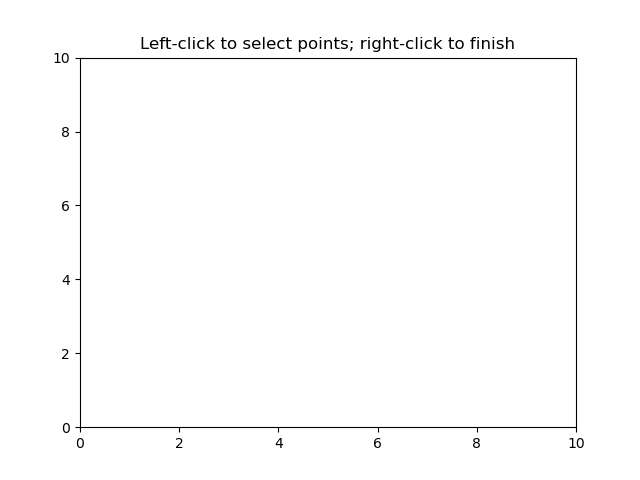

In [13]:
%matplotlib widget
segments = get_segments()

Zwizualizuj wprowadzone odcinki

[((np.float64(2.1370967741935485), np.float64(7.878787878787879)), (np.float64(7.399193548387096), np.float64(2.548701298701299))), ((np.float64(2.5201612903225805), np.float64(2.954545454545455)), (np.float64(8.225806451612902), np.float64(6.363636363636364))), ((np.float64(2.6612903225806455), np.float64(5.1190476190476195)), (np.float64(5.826612903225806), np.float64(2.7110389610389616))), ((np.float64(4.435483870967742), np.float64(1.7640692640692643)), (np.float64(7.318548387096774), np.float64(4.388528138528139))), ((np.float64(5.725806451612904), np.float64(7.121212121212121)), (np.float64(8.931451612903226), np.float64(4.388528138528139))), ((np.float64(1.592741935483871), np.float64(8.933982683982684)), (np.float64(9.294354838709676), np.float64(8.636363636363637)))]


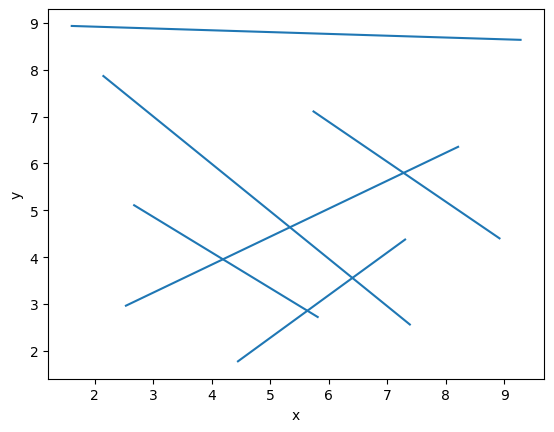

In [14]:
%matplotlib inline
draw_segments(segments)
print(segments)

## Wczytywanie odcinków z pliku

In [16]:
def load_segments_from_file(pathToFile: str):
    loadedSegments = []
    try:
        with open(pathToFile, 'r') as file:
            for line in file:
                beg1, end1, beg2, end2 = list(map(np.float64, line.strip().split()))
                loadedSegments.append(((beg1, end1), (beg2, end2)))
    except FileNotFoundError:
        print(f"File '{pathToFile}' not found.")
    except ValueError:
        print("Invalid format in file. Each line should contain four floats separated by whitespace.")

    return loadedSegments

In [17]:
pathToFile = "./test_segments/test1"
loadedSegments = load_segments_from_file(pathToFile)

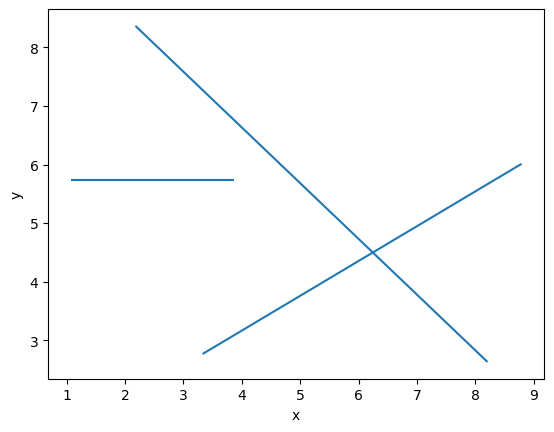

In [18]:
vis = Visualizer()
vis.add_line_segment(loadedSegments)
vis.show()

## Wykorzystywane struktury

In [19]:
from sortedcontainers import SortedSet

In [20]:
class Point:
    def __init__(self, point: tuple[float, float]) -> None:
        self.point = point

    def get_point(self):
        return self.point

    def get_x(self):
        return self.point[0]

    def get_y(self):
        return self.point[1]

    def __lt__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() < other.get_x()

    def __le__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() <= other.get_x()

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Point):
            return NotImplemented
        return self.point == value.point

    def __hash__(self) -> int:
        return hash(self.point)

    def __repr__(self) -> str:
        return f"Point({self.get_x()}, {self.get_y()})"

In [21]:
class Segment:
    # współdzielona wartość obecnej wpółrzędnej x

    x = None
    eps = None

    def __init__(self, beg: Point, end: Point) -> None:
        # ustawienie początku jako punktu z mniejszą wartością współrzędnej x
        if end < beg:
            beg, end = end, beg

        self.beg = beg
        self.end = end

        # wyznaczenie współczynników a i b do równania kierunkowego prostej
        self.a = (end.get_y() - beg.get_y()) / (end.get_x() - beg.get_x())
        self.b = -self.a * beg.get_x() + beg.get_y()

    @staticmethod
    def update_x(x):
        Segment.x = x

    @staticmethod
    def set_eps(eps):
        Segment.eps = eps

    def get_segment(self):
        return (self.beg.get_point(), self.end.get_point())

    def get_beg(self):
        return self.beg

    def get_end(self):
        return self.end

    def get_a(self):
        return self.a

    def get_b(self):
        return self.b

    def calculate_y_coordinate(self):
        return self.a * Segment.x + self.b

    def __lt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented

        thisY = self.calculate_y_coordinate()
        otherY = other.calculate_y_coordinate()

        # check if y-coordinates are approximately the same
        if abs(thisY - otherY) < Segment.eps:
            return False

        return thisY < otherY

    def __le__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented

        thisY = self.calculate_y_coordinate()
        otherY = other.calculate_y_coordinate()

        # check if y-coordinates are approximately the same
        if abs(thisY - otherY) < Segment.eps:
            return True

        return thisY <= otherY

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Segment):
            return NotImplemented
        reslut = self.get_beg() == value.get_beg() and self.get_end() == value.get_end()
        # TODO: remove
        # print(self, value)
        # print(f"cmp reslut: {reslut}")
        return reslut

    def __hash__(self) -> int:
        return hash((self.beg, self.end))

    def __repr__(self) -> str:
        return f"Segment({self.beg}, {self.end})"

In [22]:
class Event:
    def __init__(self, point: Point, eventType, segmentsList: list[Segment]) -> None:
        self.point = point
        self.eventType = eventType
        self.segmentsList = segmentsList

    def get_event_point(self):
        return self.point

    def get_event_type(self):
        return self.eventType

    def get_event_segments_list(self):
        return self.segmentsList

    def __lt__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__lt__(other.get_event_point())

    def __le__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__le__(other.get_event_point())

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Event):
            return NotImplemented
        return self.eventType == value.eventType and self.get_event_point() == value.get_event_point()

    def __hash__(self) -> int:
        return hash((self.point, self.eventType))

    def __repr__(self) -> str:
        return f"Event({self.point, self.eventType})"

Uzupełnij funkcję ```get_segments_intersection``` znajdującą przecięcie dwóch odcinków

In [23]:
def mat_det_2x2(kx1, kx2, ky1, ky2):
    """
    Obliczanie wyznacznika macierzy 2x2 bez użycia funkcji bibliotecznych

    :param kx1: współczynnik przed x w pierwszym równaniu
    :param kx2: współczynnik przed x w drugim równaniu
    :param ky1: współczynnik przed y w pierwszym równaniu
    :param ky2: współczynnik przed y w drugim równaniu
    :return: wartość wyznacznika macierzy
    """

    return kx1 * ky2 - kx2 * ky1

In [24]:
def get_segments_intersection(segment1: Segment, segment2: Segment) -> Point:
    """
    Wyznacza punkt przecięcia odcinków

    :param segment1: pierwszy odcinek
    :param segment2: drugi odcinek
    :return: punkt przecięcia odcinków
    """
    if segment1.get_a() == segment2.get_a():
        return None

    W = mat_det_2x2(segment1.get_a(), segment2.get_a(), -1, -1)
    Wx = mat_det_2x2(-segment1.get_b(), -segment2.get_b(), -1, -1)
    Wy = mat_det_2x2(segment1.get_a(), segment2.get_a(), -segment1.get_b(), -segment2.get_b())

    intersectPoint = Point((Wx / W, Wy / W))

    if segment1.get_beg().get_x() < intersectPoint.get_x() < segment1.get_end().get_x() \
       and segment2.get_beg().get_x() < intersectPoint.get_x() < segment2.get_end().get_x():
        return intersectPoint

    return None

False
Segment(Point(1.5, 1), Point(2, 4))
Segment(Point(1, 3), Point(3, 1))
Segment(Point(-1, 3), Point(100, 5))
Segment(Point(-1, 3), Point(100, 5))
Point(1.7142857142857142, 2.2857142857142856)
2.2857142857142847
2.2857142857142856
False


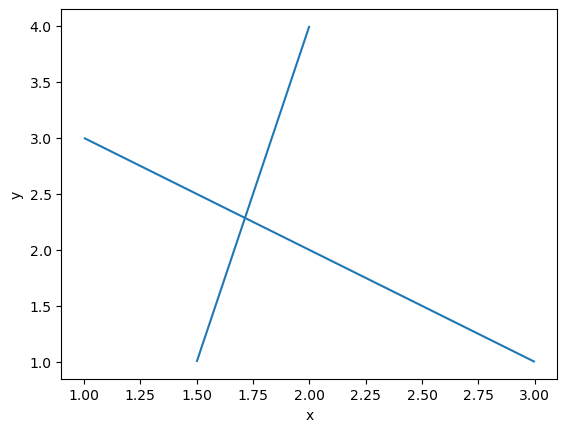

In [25]:
# TODO: remove
%matplotlib inline
end1 = Point((1.5,1))
beg1 = Point((2,4))
beg2 = Point((1,3))
end2 = Point((3,1))
seg1 = Segment(beg1, end1)
seg2 = Segment(beg2, end2)

print(beg1 < end1)

print(seg1)
print(seg2)

print(Segment(Point((100, 5)), Point((-1, 3))))
print(Segment(Point((-1, 3)), Point((100, 5))))

intersectPoint = get_segments_intersection(seg1, seg2)
print(intersectPoint)
if intersectPoint is not None:
    Segment.update_x(intersectPoint.get_x())
    Segment.set_eps(EPS)
    print(seg1.calculate_y_coordinate())
    print(seg2.calculate_y_coordinate())
    print(seg1 < seg2)

draw_segments([seg1.get_segment(), seg2.get_segment()])

## Przecinanie się odcinków

In [27]:
# TODO: remove
sortedSet = SortedSet()
segment1 = Segment(Point((2.1774193548387095, 8.365800865800868)), Point((5.205645161290322, 3.62987012987013)))
segment2 = Segment(Point((1.1774193548387095, 2.365800865800868)), Point((4.205645161290322, 1.62987012987013)))
segment3 = Segment(Point((3.1774193548387095, 8.365800865800868)), Point((6.205645161290322, 2.62987012987013)))
Segment.update_x(segment1.get_beg().get_x())
sortedSet.add(segment1)
Segment.update_x(segment2.get_beg().get_x())
sortedSet.add(segment2)
Segment.update_x(segment3.get_beg().get_x())
sortedSet.add(segment3)
print(sortedSet)
Segment.update_x(segment1.get_end().get_x())
sortedSet.remove(segment1)
print(sortedSet)
Segment.update_x(segment3.get_end().get_x())
sortedSet.remove(segment3)
print(sortedSet)
Segment.update_x(segment2.get_end().get_x())
sortedSet.remove(segment2)
print(sortedSet)

SortedSet([Segment(Point(1.1774193548387095, 2.365800865800868), Point(4.205645161290322, 1.62987012987013)), Segment(Point(2.1774193548387095, 8.365800865800868), Point(5.205645161290322, 3.62987012987013)), Segment(Point(3.1774193548387095, 8.365800865800868), Point(6.205645161290322, 2.62987012987013))])
SortedSet([Segment(Point(1.1774193548387095, 2.365800865800868), Point(4.205645161290322, 1.62987012987013)), Segment(Point(3.1774193548387095, 8.365800865800868), Point(6.205645161290322, 2.62987012987013))])
SortedSet([Segment(Point(1.1774193548387095, 2.365800865800868), Point(4.205645161290322, 1.62987012987013))])
SortedSet([])


Uzupełnij funkcję ```is_intersection```

In [28]:
def is_intersection_handle_event_beg(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    return foundIntersection

In [29]:
def is_intersection_handle_event_end(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            foundIntersection =True

    broomStateStruct.remove(toRemoveSegment)

    return foundIntersection

In [30]:
def is_intersection(segments, eps = EPS):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina

    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """

    isIntersection = False

    # ustawienie wartości epsilon do porównywania odcinków
    Segment.set_eps(eps)

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    # firstEventPoint = firstEvent.get_event_point()      # TODO: remove
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])

    # # TODO: TEST (to remove)

    # secondEvent: Event = eventsSortedSet.pop(0)
    # secondEventPoint = secondEvent.get_event_point()

    # Segment.update_x(secondEventPoint.get_x())
    # broomStateStruct.add(secondEvent.get_event_segments_list()[0])

    # print(*broomStateStruct, sep="\n")

    # # TODO: swap elements (to remove)
    # topSegment = firstEvent.get_event_segments_list()[0]
    # bottomSegment = secondEvent.get_event_segments_list()[0]
    # intersectPoint = get_segments_intersection(topSegment, bottomSegment)

    # print(intersectPoint)

    # Segment.update_x(intersectPoint.get_x())

    # broomStateStruct.remove(topSegment)
    # broomStateStruct.remove(bottomSegment)

    # broomStateStruct.add(bottomSegment)
    # print("\n\n")

    # print(*broomStateStruct, sep="\n")

    # print("\n\n")

    # broomStateStruct.add(topSegment)
    # print(*broomStateStruct, sep="\n")

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        # print(event)

        if eventType == BEG:
            if is_intersection_handle_event_beg(event, broomStateStruct):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_handle_event_end(event, broomStateStruct):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")

    return isIntersection

In [31]:
isIntersection = is_intersection(segments)
print(isIntersection)

True


In [32]:
isIntersection = is_intersection(loadedSegments)
print(isIntersection)

True


In [33]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

In [ ]:
# Odpowiedź here
# TODO: answer

Uzupełnij funkcję ```is_intersection_with_visualization```

In [34]:
def get_broom(point: Point):
    return ((point.get_x(), 0), (point.get_x(), 1))

In [35]:
def is_intersection_with_visualization_handle_event_beg(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # dodanie wizualizacji dodania nowego odcinka do struktury stanu miotły
    vis.add_line_segment(eventSegment.get_segment(), **IN_BROOM_STRUCT)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    return False

In [36]:
def is_intersection_with_visualization_handle_event_end(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            vis.add_point(neighboursIntersectPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    broomStateStruct.remove(toRemoveSegment)

    # wizualizacja usunięcia odcinka ze struktury miotły
    vis.add_line_segment(toRemoveSegment.get_segment(), **PROCESSED_SEGMENTS)

    return False

In [37]:
def is_intersection_with_visualization(segments, eps = EPS):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji
    :param segments: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """

    # ustawienie początkowe vizualizera
    vis = Visualizer()
    vis.add_line_segment(segments, **NOT_PROCESSED_SEGMENTS)
    broom = None
    broomVis = None
    prevPoint = None

    isIntersection = False

    # ustawienie wartości epsilon do porównywania odcinków
    Segment.set_eps(eps)

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    # wyświetlenie wszystkich punktów stanowiących zdarzenia
    points = [event.get_event_point().get_point() for event in eventsSortedSet]
    vis.add_point(points, **IN_EVENTS_STRUCT)

    firstEvent: Event = eventsSortedSet.pop(0)

    # wizualizacja pierwszego zdarzenia
    firstEventPoint = firstEvent.get_event_point()
    broom = get_broom(firstEventPoint)
    vis.add_point(firstEventPoint.get_point(), **CURRENT_VERTEX)
    broomVis = vis.add_line(broom, **BROOM)
    prevPoint = firstEventPoint

    firstEventSegment = firstEvent.get_event_segments_list()[0]

    broomStateStruct.add(firstEventSegment)

    # dodanie nowego odcinka do struktury miotły
    vis.add_line_segment(firstEventSegment.get_segment(), **IN_BROOM_STRUCT)

    while len(eventsSortedSet) > 0:
        # zaznaczenie przetworzonego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)

        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        eventPoint = event.get_event_point()

        # dodanie wizualizacji obecnego punktu
        vis.remove_figure(broomVis)
        broom = get_broom(eventPoint)
        broomVis = vis.add_line(broom, **BROOM)
        vis.add_point(eventPoint.get_point(), **CURRENT_VERTEX)
        prevPoint = eventPoint

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        if eventType == BEG:
            if is_intersection_with_visualization_handle_event_beg(event, broomStateStruct, vis):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_with_visualization_handle_event_end(event, broomStateStruct, vis):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")


    if isIntersection:
        vis.add_title("znaleziono punkt przecięcia")
    else:
        # zaznaczenie przetworzenia ostatniego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)
        vis.add_title("nie znaleziono punktu przecięcia")

    return isIntersection, vis

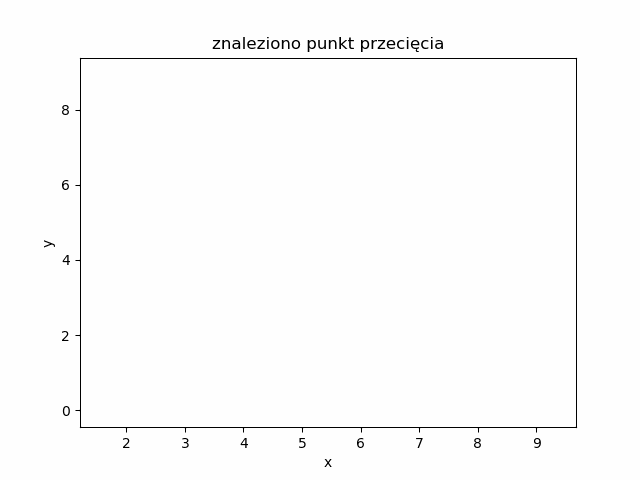

In [38]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(segments)
vis.show_gif(interval = 250)

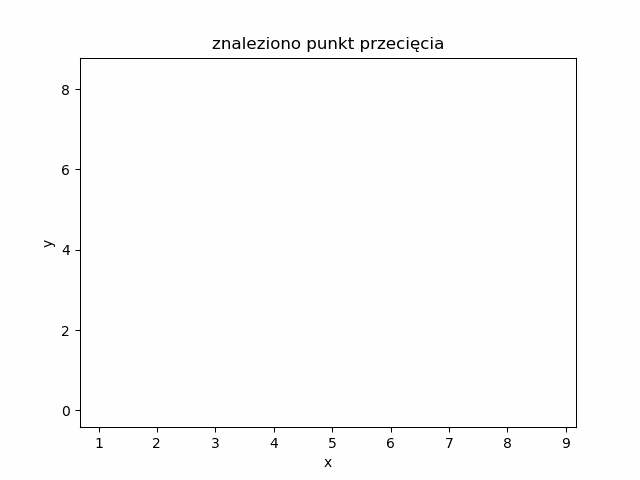

In [39]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(loadedSegments)
vis.show_gif(interval = 250)

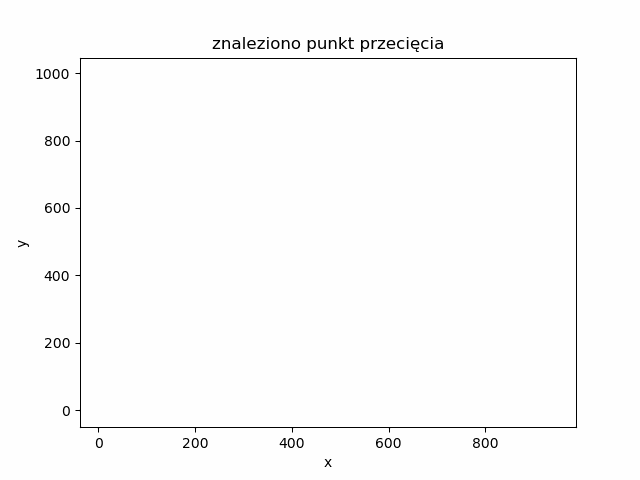

In [40]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(sections)
vis.show_gif(interval = 250)

Uzupełnij funkcję ```find_intersections```

In [91]:
def test_segments_order_correctness(broomStruct: SortedSet[Segment]):
    n = len(broomStruct)
    if n == 0:
        return
    prevSeg: Segment = broomStruct[0]
    prevY = prevSeg.calculate_y_coordinate()

    for i in range(1, n):
        seg: Segment = broomStruct[i]
        currY = seg.calculate_y_coordinate()
        # if currY <= prevY:
        if seg < prevSeg:
            print(f"Segment.x = {Segment.x}")
            print(f"prevY = {prevY}")
            print(f"currY = {currY}")
            raise Exception("Wrong order in broom struct!!!")
        prevY = currY
        prevSeg = seg

In [42]:
def find_intersections_handle_event_beg(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersections: list[tuple[float, float]]):

    # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [precedingSegment, eventSegment])
            intersections.append(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [eventSegment, succeedingSegment])
            intersections.append(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

In [78]:
def find_intersections_handle_event_end(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersections: list[tuple[float, float]]):

    # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    # sprawdzenie czy po usunięciu obecnego odcinka nowi sąsiedzi przecinają się
    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            intersectionEvent = Event(neighboursIntersectPoint, eventType = INTERSECT, segmentsList = [precedingSegment, succeedingSegment])
            intersections.append(neighboursIntersectPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    print("before removal:")
    print(broomStateStruct)
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    toRemoveSegmentIdxRight = broomStateStruct.bisect_right(toRemoveSegment) - 1
    print(toRemoveSegment)
    print(toRemoveSegmentIdx)
    print(toRemoveSegmentIdxRight)
    print(broomStateStruct[toRemoveSegmentIdx])
    broomStateStruct.remove(toRemoveSegment)

In [82]:
def find_intersections_handle_event_intersect(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                              intersections: list[tuple[float, float]]):
    ####### zamiana odcinków miejscami  #######

    Segment.update_x(event.get_event_point().get_x())

    print("before swap:")
    print(broomStateStruct)

    prevPrecedingSegment, prevSucceedingSegment = event.get_event_segments_list()

    print("to swap:")
    print(prevPrecedingSegment)
    print(prevSucceedingSegment)

    prevPrecedingSegmentIdx = broomStateStruct.bisect_left(prevPrecedingSegment)
    broomStateStruct.pop(prevPrecedingSegmentIdx)

    prevSucceedingSegmentIdx = broomStateStruct.bisect_right(prevPrecedingSegment) - 1
    broomStateStruct.pop(prevSucceedingSegmentIdx)

    succeedingSegment, precedingSegment = prevPrecedingSegment, prevSucceedingSegment

    broomStateStruct.add(precedingSegment)
    broomStateStruct.add(succeedingSegment)

    print("after swap:")
    print(broomStateStruct)

    ####### koniec zamiany #######

    succeedingSegmentIdx = prevPrecedingSegmentIdx + 1
    # print(succeedingSegment)
    # print(succeedingSegmentIdx)

    if succeedingSegmentIdx < len(broomStateStruct) - 1:
        topNeighbour = broomStateStruct[succeedingSegmentIdx + 1]

        segmentsIntersectionPoint = get_segments_intersection(succeedingSegment, topNeighbour)
        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_x() > event.get_event_point().get_x():
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [succeedingSegment, topNeighbour])
            intersections.append(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    precedingSegmentIdx = prevPrecedingSegmentIdx

    if precedingSegmentIdx > 0:
        bottomNeighbour = broomStateStruct[precedingSegmentIdx - 1]

        segmentsIntersectionPoint = get_segments_intersection(bottomNeighbour, precedingSegment)
        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_x() > event.get_event_point().get_x():
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [bottomNeighbour, precedingSegment])
            intersections.append(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

In [92]:
def find_intersections(segments, eps = EPS):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param segments: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

    intersections = []

    # ustawienie wartości epsilon do porównywania odcinków
    Segment.set_eps(eps)

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segmentsObjects = [Segment(Point(beg), Point(end)) for beg, end in segments]

    for seg in segmentsObjects:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    # firstEventPoint = firstEvent.get_event_point()      # TODO: remove
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])

    # # TODO: TEST (to remove)

    # secondEvent: Event = eventsSortedSet.pop(0)
    # secondEventPoint = secondEvent.get_event_point()

    # Segment.update_x(secondEventPoint.get_x())
    # broomStateStruct.add(secondEvent.get_event_segments_list()[0])

    # print(*broomStateStruct, sep="\n")

    # # TODO: swap elements (to remove)
    # topSegment = firstEvent.get_event_segments_list()[0]
    # bottomSegment = secondEvent.get_event_segments_list()[0]
    # intersectPoint = get_segments_intersection(topSegment, bottomSegment)

    # print(intersectPoint)

    # Segment.update_x(intersectPoint.get_x())

    # broomStateStruct.remove(topSegment)
    # broomStateStruct.remove(bottomSegment)

    # broomStateStruct.add(bottomSegment)
    # print("\n\n")

    # print(*broomStateStruct, sep="\n")

    # print("\n\n")

    # broomStateStruct.add(topSegment)
    # print(*broomStateStruct, sep="\n")

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        print(f"\n\n######## {event} ########\n\n")
        print(eventsSortedSet)

        if eventType == BEG:
            find_intersections_handle_event_beg(event, eventsSortedSet, broomStateStruct, intersections)
        elif eventType == END:
            find_intersections_handle_event_end(event, eventsSortedSet, broomStateStruct, intersections)
        elif eventType == INTERSECT:
            find_intersections_handle_event_intersect(event, eventsSortedSet, broomStateStruct, intersections)
        else:
            raise Exception("Unknow Event type")

        test_segments_order_correctness(broomStateStruct)

    return intersections

SortedSet([Segment(Point(0, 0), Point(2, 2)), Segment(Point(-1, 3), Point(3, -1))])
Point(1.0, 1.0)
before change:
SortedSet([Segment(Point(0, 0), Point(2, 2)), Segment(Point(-1, 3), Point(3, -1))])
after change:
SortedSet([Segment(Point(-1, 3), Point(3, -1)), Segment(Point(0, 0), Point(2, 2))])
SortedSet([Segment(Point(-1, 3), Point(3, -1))])
SortedSet([Segment(Point(-1, 3), Point(3, -1))])
SortedSet([])


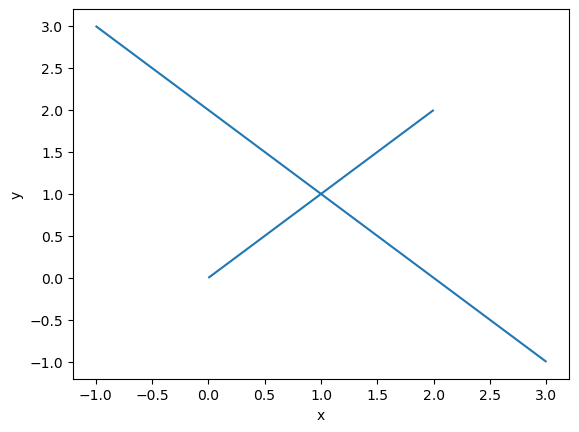

In [46]:
# TODO: remove
sortedSet = SortedSet()
segment1 = Segment(Point((0, 0)), Point((2, 2)))
segment2 = Segment(Point((-1, 3)), Point((3, -1)))
# segment3 = Segment(Point((3, 8)), Point((6, 2)))
Segment.update_x(segment2.get_beg().get_x())
sortedSet.add(segment2)
Segment.update_x(segment1.get_beg().get_x())
sortedSet.add(segment1)
# Segment.update_x(segment3.get_beg().get_x())
# sortedSet.add(segment3)
print(sortedSet)

intersectPointTest = get_segments_intersection(segment1, segment2)
print(intersectPointTest)

###### swap ######

print("before change:")
print(sortedSet)

sortedSet.remove(segment1)
sortedSet.remove(segment2)

Segment.update_x(intersectPointTest.get_x())

sortedSet.add(segment2)
sortedSet.add(segment1)

print("after change:")
print(sortedSet)

###### swap ended ######

Segment.update_x(segment1.get_end().get_x())
sortedSet.remove(segment1)
print(sortedSet)

print(sortedSet)
Segment.update_x(segment2.get_end().get_x())
sortedSet.remove(segment2)
print(sortedSet)


vis = Visualizer()
vis.add_line_segment([segment1.get_segment(), segment2.get_segment()])
vis.show()

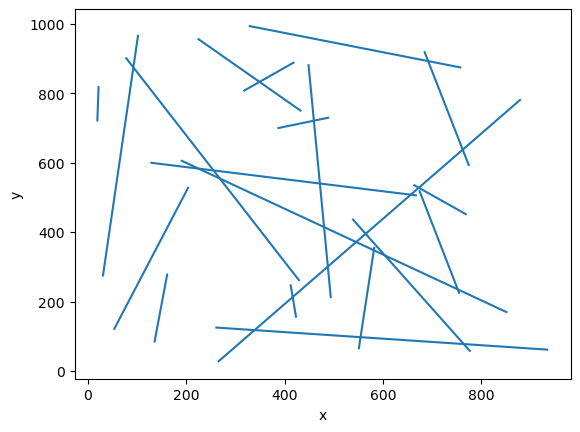

In [60]:
# TODO: remove
%matplotlib inline
vis = Visualizer()
vis.add_line_segment(sections)
vis.show()

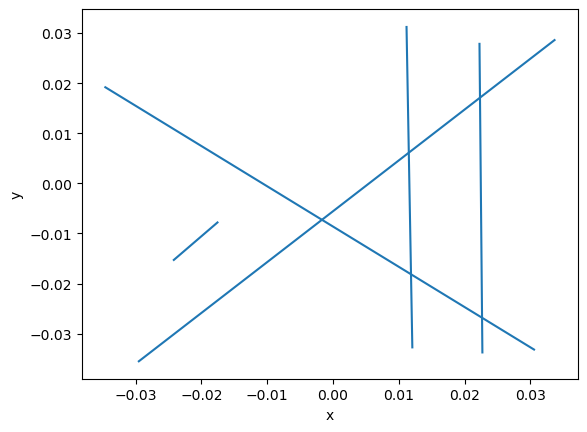

In [67]:
loadedSegments2 = load_segments_from_file("/home/wiktor/university/sem3/geometrical_algorithms/bit-algo-vis-tool/bitalg/tests/test4_tests/task3/test_4_3_1.in")
vis = Visualizer()
vis.add_line_segment(loadedSegments2)
vis.show()



######## Event((Point(-0.02962903361166678, -0.03563317233440923), 0)) ########


SortedSet([Event((Point(-0.024306452966505486, -0.015412584099115098), 0)), Event((Point(-0.017431452966505487, -0.007661358608919019), 1)), Event((Point(0.01117741800123645, 0.031431778645982955), 0)), Event((Point(0.012064514775429996, -0.032937093903036674), 1)), Event((Point(0.02226612767865581, 0.028061680606767267), 0)), Event((Point(0.022709676065752582, -0.03394812331480138), 1)), Event((Point(0.030693547033494514, -0.03327410370695825), 1)), Event((Point(0.03379838574317193, 0.028735700214610402), 1))])


######## Event((Point(-0.024306452966505486, -0.015412584099115098), 0)) ########


SortedSet([Event((Point(-0.017431452966505487, -0.007661358608919019), 1)), Event((Point(-0.0016743790516658117, -0.007263586832941072), 2)), Event((Point(0.01117741800123645, 0.031431778645982955), 0)), Event((Point(0.012064514775429996, -0.032937093903036674), 1)), Event((Point(0.02226612767865581, 0.02806168

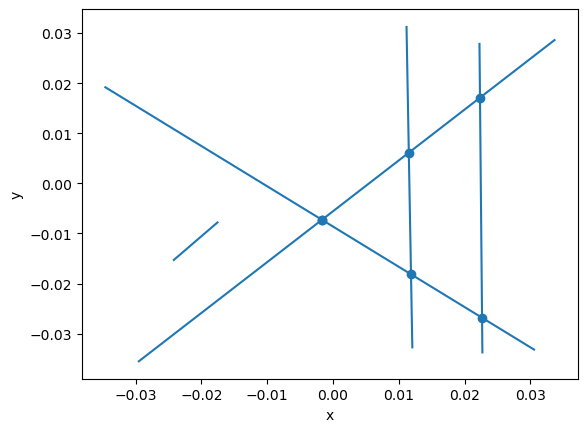

In [68]:
%matplotlib inline
# loadedSegments2 = load_segments_from_file("./test_segments/test3")
intersections = find_intersections(loadedSegments2)
print(intersections)
vis.add_point(intersections)
vis.show()

In [93]:
%matplotlib inline
intersections = find_intersections(sections)
print(intersections)
vis = Visualizer()
vis.add_line_segment(sections)
vis.add_point(intersections)
vis.show()



######## Event((Point(22.124539145912948, 820.2490964403124), 1)) ########


SortedSet([Event((Point(30.707733952210937, 272.09270158796807), 0)), Event((Point(52.99107320411645, 118.71522671132118), 0)), Event((Point(77.02376047608361, 902.9348247643209), 0)), Event((Point(102.45720190437024, 968.0338546016199), 1)), Event((Point(127.31268120063265, 599.8054060763795), 0)), Event((Point(135.58301654238824, 82.10002991475352), 0)), Event((Point(161.84584428818772, 280.5633747155035), 1)), Event((Point(189.32486450025598, 606.4777840215039), 0)), Event((Point(204.91742569910954, 529.9502797186353), 1)), Event((Point(223.43441128317698, 957.206977708994), 0)), Event((Point(259.4290828743916, 125.22468736159887), 0)), Event((Point(264.50432369915524, 26.12105964230027), 0)), Event((Point(316.3840947846555, 806.0966283017815), 0)), Event((Point(327.3968581602454, 993.651773859539), 0)), Event((Point(385.47230932001264, 699.0258040438957), 0)), Event((Point(412.3190582217495, 249.48456906

Exception: Wrong order in broom struct!!!

In [251]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: 

IndexError: tuple index out of range

Uzupełnij funkcję ```find_intersections_with_visualization```

In [ ]:
def find_intersections_with_visualization(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

In [ ]:
# Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

In [ ]:
# Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [ ]:
# testing_sections = ???

In [ ]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak?

In [ ]:
# Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.